In [1]:
# Import library
import pandas as pd 
import numpy as np 
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity 
import time 
import matplotlib.pyplot as plt

c:\Users\rajna\.conda\envs\MC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create sample fashion products
products = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes", "vibes": ["boho", "festival", "earthy"]},
    {"name": "Urban Jacket", "desc": "Sleek black bomber jacket for city nights", "vibes": ["urban", "edgy", "modern"]},
    {"name": "Cozy Sweater", "desc": "Warm knit sweater for comfortable lounging", "vibes": ["cozy", "comfort", "warm"]},
    {"name": "Chic Blouse", "desc": "Elegant silk blouse for sophisticated evenings", "vibes": ["chic", "elegant", "sophisticated"]},
    {"name": "Vintage Jeans", "desc": "Distressed denim with retro wash", "vibes": ["vintage", "retro", "casual"]},
    {"name": "Athletic Set", "desc": "Energy-boosting workout clothes for active lifestyle", "vibes": ["energetic", "athletic", "sporty"]},
    {"name": "Minimalist Tee", "desc": "Clean, simple design for versatile styling", "vibes": ["minimalist", "modern", "versatile"]},
    {"name": "Statement Skirt", "desc": "Bold patterns and vibrant colors for attention", "vibes": ["bold", "vibrant", "dramatic"]}
]

In [3]:
#Create DataFrame
df = pd.DataFrame(products)

In [4]:
print(df[['name','desc']])

              name                                               desc
0       Boho Dress             Flowy, earthy tones for festival vibes
1     Urban Jacket          Sleek black bomber jacket for city nights
2     Cozy Sweater         Warm knit sweater for comfortable lounging
3      Chic Blouse     Elegant silk blouse for sophisticated evenings
4    Vintage Jeans                   Distressed denim with retro wash
5     Athletic Set  Energy-boosting workout clothes for active lif...
6   Minimalist Tee         Clean, simple design for versatile styling
7  Statement Skirt     Bold patterns and vibrant colors for attention


I'm sorry but I don't have the paid version of ChatGPT's embedding model which is why I'm using another embedding model.

In [5]:
# Load the model 
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [6]:
def generate_embeddings(texts):
    return model.encode(texts,show_progress_bar=True) 

# Generate embeddings for product descriptions
product_descriptions =df['desc'].tolist()
product_embeddings = generate_embeddings(product_descriptions)
 
df['enbedding'] = list(product_embeddings)
print(f'Generate {len(product_embeddings)} embeddings with dimension {product_embeddings.shape[1]}')

Batches: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]

Generate 8 embeddings with dimension 384


In [7]:
def find_similar_products(query, top_k=3, similarity_threshold=0.3):
    start_time = time.time()
    
    # Generate query embedding
    query_embedding = generate_embeddings([query])
    
    # Compute cosine similarity
    similarities = cosine_similarity(query_embedding, product_embeddings)[0]
    
    # Get top-k matches
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Prepare results
    results = []
    for idx in top_indices:
        if similarities[idx] > similarity_threshold:
            results.append({
                'name': df.iloc[idx]['name'],
                'description': df.iloc[idx]['desc'],
                'vibes': df.iloc[idx]['vibes'],
                'similarity_score': similarities[idx],
                'match_quality': 'good' if similarities[idx] > 0.7 else 'fair'
            })
        else:
            # Fallback for no good matches
            results.append({
                'name': "No strong match found",
                'description': "Try refining your vibe query",
                'vibes': [],
                'similarity_score': similarities[idx],
                'match_quality': 'poor'
            })
            break
    
    latency = time.time() - start_time
    return results, latency

In [8]:
def vibe_matcher(query, top_k=3):
    print(f"Searching for: '{query}'")
    print("*"* 50)
    
    results, latency = find_similar_products(query, top_k)
    
    for i, result in enumerate(results):
        print(f"\n#{i+1} | Score: {result['similarity_score']:.3f} | {result['match_quality'].upper()} MATCH")
        print(f"Product: {result['name']}")
        print(f"Description: {result['description']}")
        print(f"Vibes: {result['vibes']}")
    
    print(f"Latency: {latency:.4f} seconds")
    return results, latency

In [9]:
# test queries 
test_queries = [
    "energetic urban chic",
    "cozy comfortable warmth", 
    "elegant sophisticated evening"
]

In [10]:
test_queries = [
    "energetic urban chic",
    "cozy comfortable warmth", 
    "elegant sophisticated evening"
]

In [11]:
# Evaluation metrics
results_log = []
for query in test_queries:
    results, latency = vibe_matcher(query)
    
    for result in results:
        results_log.append({
            'query': query,
            'product': result['name'],
            'score': result['similarity_score'],
            'quality': result['match_quality'],
            'latency': latency
        })

Searching for: 'energetic urban chic'
**************************************************


Batches: 100%|██████████| 1/1 [00:00<00:00, 41.18it/s]



#1 | Score: 0.354 | FAIR MATCH
Product: Urban Jacket
Description: Sleek black bomber jacket for city nights
Vibes: ['urban', 'edgy', 'modern']

#2 | Score: 0.354 | FAIR MATCH
Product: Athletic Set
Description: Energy-boosting workout clothes for active lifestyle
Vibes: ['energetic', 'athletic', 'sporty']

#3 | Score: 0.352 | FAIR MATCH
Product: Boho Dress
Description: Flowy, earthy tones for festival vibes
Vibes: ['boho', 'festival', 'earthy']
Latency: 0.0373 seconds
Searching for: 'cozy comfortable warmth'
**************************************************


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.91it/s]



#1 | Score: 0.592 | FAIR MATCH
Product: Cozy Sweater
Description: Warm knit sweater for comfortable lounging
Vibes: ['cozy', 'comfort', 'warm']

#2 | Score: 0.289 | POOR MATCH
Product: No strong match found
Description: Try refining your vibe query
Vibes: []
Latency: 0.0336 seconds
Searching for: 'elegant sophisticated evening'
**************************************************


Batches: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


#1 | Score: 0.622 | FAIR MATCH
Product: Chic Blouse
Description: Elegant silk blouse for sophisticated evenings
Vibes: ['chic', 'elegant', 'sophisticated']

#2 | Score: 0.410 | FAIR MATCH
Product: Minimalist Tee
Description: Clean, simple design for versatile styling
Vibes: ['minimalist', 'modern', 'versatile']

#3 | Score: 0.404 | FAIR MATCH
Product: Boho Dress
Description: Flowy, earthy tones for festival vibes
Vibes: ['boho', 'festival', 'earthy']
Latency: 0.0260 seconds


In [12]:
# Create evaluation dataframe
eval_df = pd.DataFrame(results_log)
# Calculate metrics
avg_latency = eval_df['latency'].mean()
good_matches = len(eval_df[eval_df['quality'] == 'good'])
total_matches = len(eval_df)

print(f"\nEVALUATION SUMMARY")
print(f"Total Queries Tested: {len(test_queries)}")
print(f"Good Matches (score > 0.7): {good_matches}/{total_matches} ({good_matches/total_matches*100:.1f}%)")
print(f"Average Latency: {avg_latency:.4f} seconds")


EVALUATION SUMMARY
Total Queries Tested: 3
Good Matches (score > 0.7): 0/8 (0.0%)
Average Latency: 0.0321 seconds


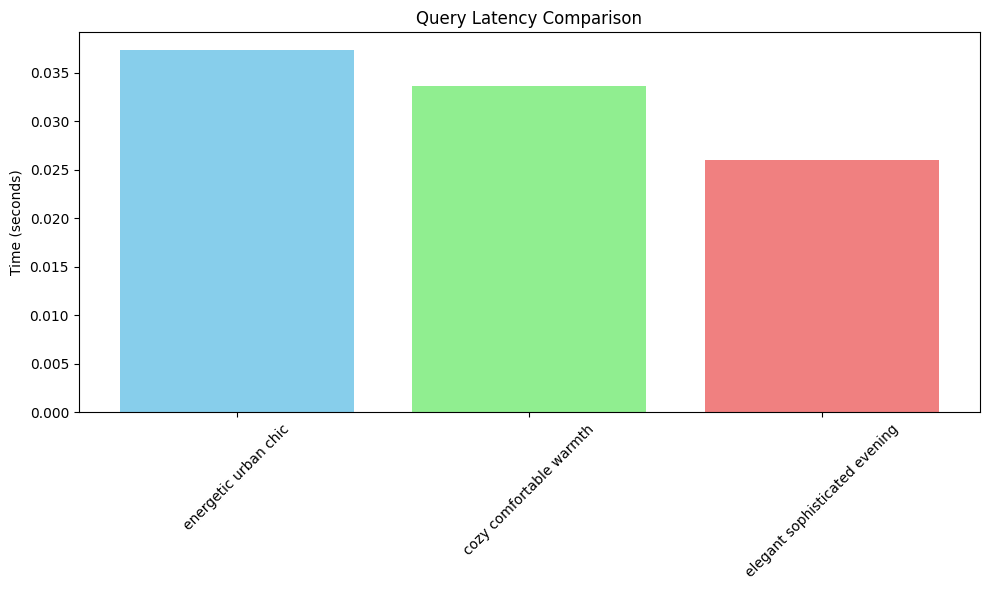

In [13]:
# Latency visualization
plt.figure(figsize=(10, 6))
latency_data = [eval_df[eval_df['query'] == query]['latency'].iloc[0] for query in test_queries]
plt.bar(test_queries, latency_data, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Query Latency Comparison')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()